# BTL mở rộng môn Học Máy, mã môn học CO3117 - Hidden model Markov
## **Thông tin nhóm**

+ **Tên nhóm** : MLP2
+ **Giảng viên hướng dẫn**: TS. Lê Thành Sách
+ **Thành viên** :

    | **MSSV** | **Họ và tên** |
    |:---|:---:|
    | 2312046 | Bùi Ngọc Minh |
    | 2313233 | Lê Trọng Thiện |




In [18]:
import numpy as np

## 1. Thuật toán Forward

Thuật toán **Forward** được sử dụng để giải quyết bài toán 1 của HMM: Tính toán xác suất của một chuỗi quan sát $P(O | \lambda)$ cho trước, với mô hình $\lambda = (A, B, \pi)$.

Thuật toán này sử dụng quy hoạch động để tính biến $\alpha_t(i)$, là xác suất của chuỗi quan sát $O_1, O_2, ..., O_t$ và trạng thái tại thời điểm $t$ là $S_i$.

- **Khởi tạo:** $\alpha_1(i) = \pi_i b_i(O_1)$
- **Truy hồi:** $\alpha_{t+1}(j) = \left[ \sum_{i=1}^{N} \alpha_t(i) a_{ij} \right] b_j(O_{t+1})$
- **Kết thúc:** $P(O | \lambda) = \sum_{i=1}^{N} \alpha_T(i)$

In [19]:
def forward(obs, A, B, pi):
    N = A.shape[0]
    T = len(obs)
    alpha = np.zeros((T, N))
    alpha[0, :] = pi * B[:, obs[0]]
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1, :] * A[:, j]) * B[j, obs[t]]
    return np.sum(alpha[-1, :]), alpha

## 2. Thuật toán Backward

Thuật toán **Backward** tương tự như Forward nhưng tính toán ngược từ cuối chuỗi. Biến $\beta_t(i)$ được định nghĩa là xác suất của chuỗi quan sát từ $t+1$ đến cuối ($O_{t+1}, ..., O_T$), cho biết trạng thái tại thời điểm $t$ là $S_i$.

Thuật toán này thường được kết hợp với Forward trong thuật toán Baum-Welch.

- **Khởi tạo:** $\beta_T(i) = 1$
- **Truy hồi:** $\beta_t(i) = \sum_{j=1}^{N} a_{ij} b_j(O_{t+1}) \beta_{t+1}(j)$

In [20]:
def backward(obs, A, B):
    N = A.shape[0]
    T = len(obs)
    beta = np.zeros((T, N))
    beta[T-1, :] = 1
    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, obs[t+1]] * beta[t+1, :])

    return beta

## 3. Thuật toán Baum-Welch 

Thuật toán **Baum-Welch** (còn gọi là Forward-Backward) được sử dụng để giải quyết bài toán 3: Huấn luyện mô hình (ước lượng tham số $\lambda = (A, B, \pi)$) từ một chuỗi quan sát $O$. Đây là một trường hợp đặc biệt của thuật toán Expectation-Maximization (EM).

1.  **E-step (Expectation):** Tính toán các biến $\gamma_t(i)$ (xác suất ở trạng thái $i$ tại thời điểm $t$) và $\xi_t(i, j)$ (xác suất chuyển từ trạng thái $i$ sang $j$ tại thời điểm $t$).
    - $\gamma_t(i) = \frac{\alpha_t(i) \beta_t(i)}{P(O | \lambda)}$
    - $\xi_t(i, j) = \frac{\alpha_t(i) a_{ij} b_j(O_{t+1}) \beta_{t+1}(j)}{P(O | \lambda)}$
2.  **M-step (Maximization):** Cập nhật lại các tham số $\pi$, $A$, và $B$ dựa trên các giá trị kỳ vọng đã tính.
    - $\pi_i = \gamma_1(i)$
    - $a_{ij} = \frac{\sum_{t=1}^{T-1} \xi_t(i, j)}{\sum_{t=1}^{T-1} \gamma_t(i)}$
    - $b_j(k) = \frac{\sum_{t=1 \text{ s.t. } O_t=k}^{T} \gamma_t(j)}{\sum_{t=1}^{T} \gamma_t(j)}$

Hàm `baum_welch` dưới đây thực hiện lặp lại hai bước E và M này `n_iter` lần để hội tụ các tham số.

In [21]:
# obs : short for observation sequence
# N : number of hidden states
# M : number of possible symbols

def baum_welch(obs, N, M, n_iter=100):
    T = len(obs)
    A = np.random.dirichlet(np.ones(N), size=N)
    B = np.random.dirichlet(np.ones(M), size=N)
    pi = np.random.dirichlet(np.ones(N))
    for _ in range(n_iter):
        P,alpha=forward(obs,A,B,pi)
        beta = backward(obs, A, B)

        xi = np.zeros((T - 1, N, N))
        for t in range(T - 1):
            denom = (alpha[t][:, None] * A * B[:, obs[t + 1]] * beta[t + 1]).sum()
            xi[t] = (alpha[t][:, None] * A * B[:, obs[t + 1]] * beta[t + 1]) / denom
        gamma = xi.sum(axis=2)
        gamma = np.vstack([gamma, (alpha[-1] * beta[-1]) / P])

        pi = gamma[0]
        A = xi.sum(axis=0) / (gamma[:-1].sum(axis=0)[:, None])

        for k in range(M):
            B[:, k] = gamma[np.array(obs) == k].sum(axis=0)
        B = B / (gamma.sum(axis=0)[:, None])

    return A, B, pi # Guessed parameters

## 4. Thuật toán Viterbi

Thuật toán **Viterbi** được sử dụng để giải quyết bài toán 2: Tìm chuỗi trạng thái ẩn $Q = (q_1, q_2, ..., q_T)$ "tốt nhất" (có xác suất cao nhất) đã sinh ra chuỗi quan sát $O$.

Đây cũng là một thuật toán quy hoạch động:
- $\delta_t(i)$ là xác suất cao nhất của chuỗi trạng thái kết thúc tại trạng thái $i$ ở thời điểm $t$.
- $\psi_t(i)$ lưu lại trạng thái "tốt nhất" ở thời điểm $t-1$ dẫn đến trạng thái $i$ ở thời điểm $t$.

- **Khởi tạo:**
    - $\delta_1(i) = \pi_i b_i(O_1)$
    - $\psi_1(i) = 0$
- **Truy hồi:**
    - $\delta_t(j) = \max_{i} [\delta_{t-1}(i) a_{ij}] b_j(O_t)$
    - $\psi_t(j) = \arg\max_{i} [\delta_{t-1}(i) a_{ij}]$
- **Kết thúc:** Tìm chuỗi trạng thái bằng cách quay lui (backtracking) từ $\psi$.

In [22]:
# obs : short for observation sequence
# A : transition probability matrix N x N
# B : state emission probability matrix N x M
# pi : initial distribution

def viterbi(obs, A, B, pi):
    N = A.shape[0]
    T = len(obs)
    delta = np.zeros((T, N)) # Max probability array for any sequence to end in state index i
    psi = np.zeros((T, N), dtype=int) # argmax back pointer

    delta[0, :] = pi * B[:, obs[0]]

    for t in range(1, T):
        for j in range(N):
            seq_probs = delta[t-1, :] * A[:, j]
            psi[t, j] = np.argmax(seq_probs)
            delta[t, j] = np.max(seq_probs) * B[j, obs[t]]

    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1, :])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]

    return states, delta, psi

## 5. Huấn luyện không giám sát (Ứng dụng dự đoán thời tiết)

Phần này sử dụng các hàm HMM đã cài đặt để dự đoán thời tiết.
- **Bài toán:** Dự đoán thời tiết cho 5 "mốc" thời gian tiếp theo (mỗi mốc 6 giờ) dựa trên dữ liệu thời tiết 2 tuần đã qua.
- **Dữ liệu:** `obs` là chuỗi quan sát thời tiết (0: Nắng, 1: Mây, 2: Mưa).
- **Trạng thái ẩn (N):** Chúng ta không biết các trạng thái ẩn (ví dụ: áp suất, độ ẩm, nhiệt độ) là gì. Ở đây ta *đoán* số lượng trạng thái ẩn là 50 (`N = 50`).
- **Huấn luyện:** Dùng `baum_welch` (học không giám sát) để tìm ra các ma trận A, B và vector pi từ chuỗi `obs`.
- **Dự đoán:** Dùng hàm `predict_next` để dự đoán 5 quan sát tiếp theo.

### Xây dựng hàm `predict_next`

In [23]:
def predict_next(obs, A, B, pi, length=1, random=True):
    #log_prob, alpha, c = forward_log_scaled(obs, A, B, pi)
    _,alpha=forward(obs, A, B, pi)
    state_dist = alpha[-1, :] / np.sum(alpha[-1, :])

    predictions = []
    for _ in range(length):
        next_state_dist = state_dist @ A
        next_obs_dist = next_state_dist @ B
        if(random):
          next_obs = np.random.choice(len(next_obs_dist), p=next_obs_dist)
          next_state = np.random.choice(len(next_state_dist), p=next_state_dist)
          state_dist = np.zeros_like(state_dist)
          state_dist[next_state] = 1.0
        else :
          next_obs = np.argmax(next_obs_dist)
          state_dist = next_state_dist
        predictions.append(next_obs)

    return predictions


### khởi chạy mô hình

In [24]:
# Test using HMM for prediction

# 0 = clear / sunny
# 1 = clouddy
# 2 = rainny
# Real weather for the past 2 weeks, each entries is 6 hours, entered at sep 29, 2025
# Manually enteredd from https://www.timeanddate.com/weather/vietnam/ho-chi-minh/historic
symbols = ["☀️", "⛅", "☔"]
obs = [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2]

N = 50 # pure guess, 2 humidity level * 5 temperatures * 10
M = 3
A, B, pi = baum_welch(obs, N, M,500)
for i in range(10):
  print([symbols[i] for i in predict_next(obs, A, B, pi, 5)])



['⛅', '⛅', '☀️', '☀️', '⛅']
['☔', '⛅', '☀️', '☀️', '⛅']
['☔', '⛅', '☀️', '☀️', '☀️']
['☔', '☔', '☔', '☔', '☔']
['⛅', '⛅', '☀️', '☀️', '☀️']
['⛅', '⛅', '☀️', '☀️', '☀️']
['☔', '⛅', '☀️', '☀️', '⛅']
['☔', '⛅', '☀️', '☀️', '☀️']
['⛅', '☔', '☔', '☔', '☔']
['☔', '☔', '☔', '☔', '☀️']


In [25]:
print([symbols[i] for i in predict_next(obs, A, B, pi, 5,False)])

['⛅', '⛅', '☀️', '☔', '⛅']


### Nhận xét & đánh giá

**Nhận xét kết quả**

- Mô hình HMM được huấn luyện bằng thuật toán Baum–Welch có khả năng học được xu hướng thời tiết dựa trên chuỗi quan sát trong quá khứ.
- Khi dự đoán với chế độ ngẫu nhiên (`random=True`), kết quả thể hiện sự đa dạng dựa trên phân phối xác suất, phù hợp cho mô phỏng và tạo nhiều kịch bản khả dĩ.
- Khi dự đoán với chế độ chọn xác suất cao nhất (`random=False`), mô hình có xu hướng hội tụ vào một trạng thái ổn định (ví dụ: nhiều lần dự đoán trạng thái "cloudy"), phản ánh tính chu kỳ và độ lặp lại trong dữ liệu.
- Mô hình cho thấy khả năng mô phỏng tương đối tốt xu hướng ngắn hạn, tuy nhiên độ chính xác phụ thuộc lớn vào số lượng và chất lượng dữ liệu huấn luyện.

**Ưu điểm**

- Khả năng mô hình hóa chuỗi thời gian có trạng thái ẩn mà dữ liệu quan sát không phản ánh trực tiếp.
- Thuật toán Baum–Welch giúp tự động học tham số và tối ưu đường đi, không yêu cầu dữ liệu gán nhãn trạng thái ẩn.
- Có thể sinh dự đoán theo hai dạng: *xác định* và *ngẫu nhiên*, phù hợp cho mô phỏng nhiều kịch bản.

**Hạn chế**

- Dữ liệu quan sát hạn chế (ngắn, đơn chiều) khiến mô hình dễ hội tụ sớm vào một trạng thái lặp lại, thiếu khả năng phản ánh sự thay đổi đột ngột của thời tiết.
- Không xem xét thêm các biến phụ như nhiệt độ, độ ẩm, tốc độ gió, nên việc dự đoán chỉ dựa trên lịch sử là chưa đủ để thể hiện tính phức tạp thực tế.
- Mô hình HMM chỉ nắm bắt quan hệ Markov bậc 1 và phân phối phát xạ độc lập, nên khó phản ánh mối liên hệ phụ thuộc dài hạn hoặc ngữ cảnh rộng.

## 6. Huấn luyện có giám sát (Phân loại từ)

Khác với bài toán thời tiết (không giám sát, dùng Baum-Welch), ở đây chúng ta có dữ liệu huấn luyện *đã được gán nhãn* (biết cả từ và nhãn từ loại của nó).

Do đó, ta có thể ước lượng các tham số $\lambda = (A, B, \pi)$ bằng cách đếm trực tiếp tần suất của chúng từ tập `train_sents`:

1.  **Vector $\pi$ (Initial Probabilities):** Đếm tần suất một nhãn (ví dụ: 'NOUN') xuất hiện ở *đầu* câu.
    - $\pi_i = \frac{\text{Số câu bắt đầu bằng nhãn } i}{\text{Tổng số câu}}$

2.  **Ma trận A (Transition Probabilities):** Đếm tần suất một nhãn (ví dụ: 'VERB') xuất hiện *sau* một nhãn khác (ví dụ: 'NOUN').
    - $a_{ij} = P(q_{t+1} = \text{nhãn } j | q_t = \text{nhãn } i) = \frac{\text{Số lần (nhãn i, nhãn j) xuất hiện}}{\text{Số lần nhãn i xuất hiện}}$

3.  **Ma trận B (Emission Probabilities):** Đếm tần suất một từ (ví dụ: 'book') được sinh ra từ một nhãn (ví dụ: 'NOUN').
    - $b_j(k) = P(O_t = \text{từ } k | q_t = \text{nhãn } j) = \frac{\text{Số lần (từ k, nhãn j) xuất hiện}}{\text{Số lần nhãn j xuất hiện}}$



###  Tải và chuẩn bị dữ liệu

Các câu đã được gán nhãn được tải từ bộ dữ liệu Treebank của NLTK. Ta sử dụng `universal_tagset` để có một bộ nhãn đơn giản (ví dụ: 'NOUN', 'VERB', 'ADJ', ...).

Sau đó, chúng ta chia dữ liệu thành hai tập:
- `train_sents`: Dùng để huấn luyện (tính toán các ma trận A, B, pi).
- `test_sents`: Dùng để đánh giá độ chính xác của mô hình.

In [26]:
import nltk
nltk.download('universal_tagset')
tagged_sents = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

print(f"Total sents: {len(tagged_sents)}")
print("Example:", tagged_sents[0])
print("-" * 30)
from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(tagged_sents, test_size=0.2, random_state=42)

print(f"Train: {len(train_sents)}")
print(f"Test: {len(test_sents)}")

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Total sents: 3914
Example: [('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]
------------------------------
Train: 3131
Test: 783


### Xây dựng Vocabulary và Ánh xạ (Mappings)

In [27]:


vocab = set()
tags = set()
for sent in train_sents:
    for word, tag in sent:
        vocab.add(word)
        tags.add(tag)

vocab.add("<UNK>")
UNK_TOKEN = "<UNK>"


word_to_id = {word: i for i, word in enumerate(vocab)}
tag_to_id = {tag: i for i, tag in enumerate(tags)}

id_to_word = {i: word for word, i in word_to_id.items()}
id_to_tag = {i: tag for tag, i in tag_to_id.items()}

UNK_ID = word_to_id[UNK_TOKEN]

N = len(tags)
M = len(vocab)

print(f"Number of tags: {N}")
print(f"Number of observations: {M}")
print("Tags:", tags)


Number of tags: 12
Number of observations: 11050
Tags: {'PRT', 'X', 'CONJ', 'PRON', 'ADP', 'ADV', '.', 'DET', 'NUM', 'ADJ', 'NOUN', 'VERB'}


### Huấn luyện (Tính toán A, B, pi) - Supervised Training

In [28]:


pi = np.zeros(N) + 1
A = np.zeros((N, N)) + 1
B = np.zeros((N, M)) + 1
for sent in train_sents:
    if not sent:
        continue

    start_tag_id = tag_to_id[sent[0][1]]
    pi[start_tag_id] += 1

    for i in range(len(sent)):
        word, tag = sent[i]
        word_id = word_to_id.get(word, UNK_ID)
        tag_id = tag_to_id[tag]

        B[tag_id, word_id] += 1

        if i < len(sent) - 1:
            next_tag = sent[i+1][1]
            next_tag_id = tag_to_id[next_tag]
            A[tag_id, next_tag_id] += 1
pi = pi / np.sum(pi)
A = A / np.sum(A, axis=1, keepdims=True)
B = B / np.sum(B, axis=1, keepdims=True)





### Đánh giá mô hình (Evaluation)

Total words: 20549
Correct words: 18411
              precision    recall  f1-score   support

           .       0.96      1.00      0.98      2354
         ADJ       0.79      0.70      0.75      1316
         ADP       0.87      0.97      0.92      2028
         ADV       0.86      0.70      0.77       634
        CONJ       1.00      0.99      0.99       471
         DET       0.78      0.96      0.86      1795
        NOUN       0.93      0.89      0.91      5943
         NUM       0.95      0.76      0.84       727
        PRON       0.91      0.97      0.94       523
         PRT       0.88      0.94      0.91       658
        VERB       0.92      0.84      0.88      2740
           X       0.90      0.93      0.91      1360

    accuracy                           0.90     20549
   macro avg       0.90      0.89      0.89     20549
weighted avg       0.90      0.90      0.89     20549



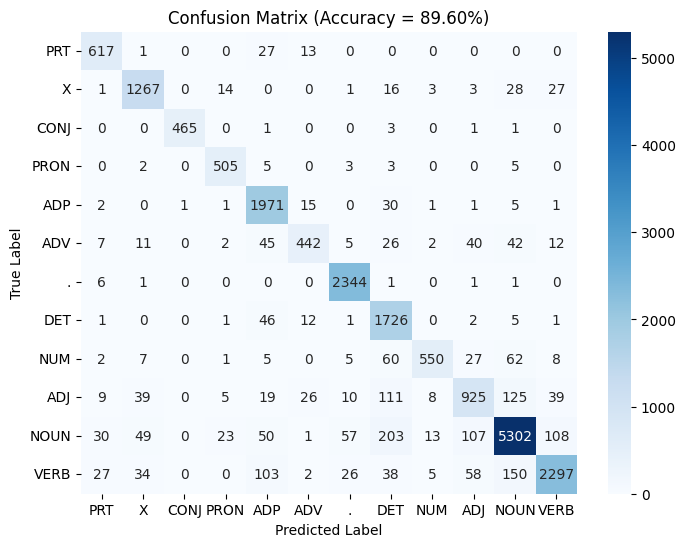

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

total_words = 0
correct_words = 0
all_true_tags = []
all_pred_tags = []

for sent in test_sents:
    if not sent:
        continue
    obs_sequence = []
    true_tags_ids = []

    for word, tag in sent:
        word_id = word_to_id.get(word, UNK_ID)
        obs_sequence.append(word_id)
        true_tags_ids.append(tag_to_id[tag])

    predicted_tags_ids, _, _ = viterbi(obs_sequence, A, B, pi)

    all_true_tags.extend(true_tags_ids)
    all_pred_tags.extend(predicted_tags_ids)

    for true_tag, pred_tag in zip(true_tags_ids, predicted_tags_ids):
        total_words += 1
        if true_tag == pred_tag:
            correct_words += 1

accuracy = (correct_words / total_words) * 100 if total_words else 0
print(f"Total words: {total_words}")
print(f"Correct words: {correct_words}")
true_labels = [id_to_tag[i] for i in all_true_tags]
pred_labels = [id_to_tag[i] for i in all_pred_tags]
tag_names = list(tag_to_id.keys())
print(classification_report(true_labels, pred_labels))

cm = confusion_matrix(true_labels, pred_labels, labels=tag_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=tag_names, yticklabels=tag_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f}%)")
plt.show()


### Nhận xét & đánh giá

**Nhận xét kết quả**

- Mô hình gán nhãn từ loại sử dụng HMM huấn luyện có giám sát đạt độ chính xác **khoảng 89.60%**, đây là mức kết quả tốt đối với mô hình thống kê cổ điển, đặc biệt trên tập dữ liệu tiếng Anh thực tế và đa dạng.
- Các nhãn như **NOUN, VERB, ADJ, ADV** được mô hình dự đoán khá chính xác với F1-score cao, chứng tỏ HMM hoạt động tốt đối với các từ loại có tần suất xuất hiện lớn và cấu trúc ngữ pháp rõ ràng.
- Một số nhãn như **CONJ, PRON, PRP, X** có kết quả thấp hơn, thể hiện rõ trên ma trận nhầm lẫn, nguyên nhân có thể do kích thước mẫu nhỏ hoặc hiện tượng trùng nghĩa/ngữ cảnh khó phân tách.
- Ma trận nhầm lẫn cho thấy sự nhầm lẫn phổ biến giữa **NOUN ↔ VERB** và **ADP ↔ ADV**, phản ánh việc HMM đôi khi khó phân biệt vai trò cú pháp theo ngữ cảnh mà chỉ dựa trên xác suất chuyển trạng thái và phát xạ.

**Ưu điểm**

- Độ chính xác cao và ổn định so với phương pháp thuần thống kê truyền thống.
- Không yêu cầu mô hình học sâu hay tài nguyên tính toán lớn, dễ triển khai và giải thích.
- Kết quả tin cậy trên các từ loại phổ biến, phù hợp với ứng dụng NLP mức cơ bản đến trung bình.
- Thuật toán cho phép mở rộng sang nhiều tác vụ chuỗi khác nhau (tagging, chunking, NER).

**Hạn chế**

- Khó xử lý ngữ cảnh dài hoặc câu phức tạp vì đặc tính Markov bậc một.
- Các nhãn hiếm hoặc linh hoạt theo ngữ cảnh (ví dụ: PRON, X, CONJ) cho kết quả chưa cao.
- Mô hình thống kê đơn thuần không tiếp thu kiến thức ngữ nghĩa, phong cách hoặc cấu trúc cú pháp sâu như mô hình học sâu (Bi-LSTM, CRF, Transformer).
- Nhầm lẫn tăng ở các cặp từ loại dễ hoán đổi vai trò trong câu, đặc biệt khi thiếu thông tin mở rộng như embedding hoặc vector ngữ cảnh.

## 7. Kết luận chung

Bài tập lớn này đã tập trung vào việc tìm hiểu lý thuyết và triển khai thực tế các thuật toán cốt lõi của Mô hình Markov ẩn (HMM) cho các bài toán xử lý chuỗi.

Nhóm đã cài đặt thành công bốn thuật toán nền tảng:
1.  **Thuật toán Forward:** Tính toán xác suất của một chuỗi quan sát.
2.  **Thuật toán Backward:** Tính toán xác suất (sử dụng trong Baum-Welch).
3.  **Thuật toán Baum-Welch (Forward-Backward):** Huấn luyện mô hình (ước lượng A, B, $\pi$) trong bối cảnh **học không giám sát**.
4.  **Thuật toán Viterbi:** Tìm chuỗi trạng thái ẩn "tốt nhất" (có xác suất cao nhất) cho một chuỗi quan sát.

Để minh họa khả năng của HMM, hai ứng dụng thực tế đã được triển khai với hai phương pháp huấn luyện khác nhau:

* **1. Huấn luyện không giám sát (Dự đoán thời tiết):**
    * Sử dụng thuật toán **Baum-Welch** để tự động học các tham số mô hình từ một chuỗi quan sát thời tiết (Nắng, Mây, Mưa) mà không biết trước các trạng thái ẩn.
    * Kết quả cho thấy mô hình có khả năng nắm bắt được các xu hướng thời tiết ngắn hạn và sinh ra các dự đoán hợp lý, mặc dù bị giới hạn bởi giả định Markov bậc một và sự đơn giản của dữ liệu đầu vào.

* **2. Huấn luyện có giám sát (Gán nhãn từ loại - POS Tagging):**
    * Tận dụng dữ liệu đã gán nhãn (tập Treebank của NLTK), các tham số mô hình (A, B, $\pi$) được ước lượng trực tiếp bằng cách **đếm tần suất** từ tập huấn luyện.
    * Thuật toán **Viterbi** sau đó được áp dụng trên tập kiểm thử để tìm chuỗi nhãn từ loại (trạng thái ẩn) tối ưu cho các câu (quan sát).
    * Mô hình đạt độ chính xác ấn tượng (khoảng **90%**), khẳng định HMM là một phương pháp thống kê cổ điển rất hiệu quả và đáng tin cậy cho các bài toán gán nhãn chuỗi trong NLP.
